In [124]:
from qutip import *
import numpy as np
from itertools import product
import random
import matplotlib.pyplot as plt

In [9]:
# Generate all possible vectors (permutations of Pauli)
ntls = 2
pauli_index = [0,1,2,3]
pauli_index_ls = [pauli_index] * ntls
# Possible ntls-dimensional vectors u
u_perm = list(product(*pauli_index_ls))

# Generate necessary Pauli ops (for testing)
pauli_ls = [qeye(2), sigmax(), sigmay(), sigmaz()]
# op[(0,1)] = tensor(qeye(2), sigmax())
#           = tensor(pauli_dic[0], pauli_ls[1])
def pauli_gen(index):
    return tensor([pauli_ls[index[i]] for i in range(len(index))])

# All possible operators with key in u_perm 
# E.g. (0,2,1) for I1Y2X3
ops = {index: pauli_gen(index) for index in u_perm}

# Possible u: 4^n
print('Number of u vectors ', len(u_perm))

Number of u vectors  16


In [32]:
commutator(ops[(3,0)], ops[(1,1)])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.  0.  0.  2.]
 [ 0.  0.  2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]]

In [35]:
H = ops[(1,1)] + ops[(0,3)] + ops[(3,0)]
D = ops[(0,3)] + ops[(3,0)]
f = commutator(H,D)
# [H,D] = -2jY1X2 -2jX1Y2
f == -2j * ops[(2,1)] - 2j * ops[(1,2)]

True

In [91]:
# Pauli product based on indexes
def pauli_commute(u, w):
    # u, w: tuples, e.g. (0,1,2,2,3) for n=5
    # Determine 0 or 2
    sgn = 1
    for i in range(len(u)):
        sgn *= (-1) ** delta(u[i], w[i])
    if sgn == (-1) ** ntls:
        return (0, 0)
    else:
        (fact, op) = pauli_prod(u, w)
        return (2 * fact, op)
    
def delta(a, b):
    if a == b or a == 0 or b == 0:
        return 1
    else:
        return 0

def pauli_prod_single(p1, p2):
    results = {
        (1,2): (1j, 3),
        (1,3): (-1j, 2),
        (2,1): (-1j, 3),
        (2,3): (1j, 1),
        (3,1): (1j, 2),
        (3,2): (-1j, 1)
    }
    if p1 == p2:
        return (1, 0)
    elif p1 == 0:
        return (1, p2)
    elif p2 == 0:
        return (1, p1)
    
    else:
        return results[(p1,p2)]

def pauli_prod(u, w):
    new = np.zeros(len(u))
    fact_new = 1
    for i in range(len(u)):
        (fact, res) = pauli_prod_single(u[i], w[i])
        fact_new *= fact
        new[i] = res
    return (fact_new, tuple(new.astype(int)))

In [92]:
pauli_commute((3,1),(3,0))

(0, 0)

In [96]:
# Gamma_u: dictionary with w as keys
# Input sigma_u, find coefficients of sigma_w
# Initialize gamma
def gamma_u_w(u, D, w):
    # D = (df, f), df constant factor, d pauli vector
    (df, d) = D
    # [u,d]=v return 0/2 if w=v, else 0
    # d be an index for a Pauli matrix in diagonal D
    (fact, v) = pauli_commute(u,d)
    if v != w:
        return 0
    else:
        return df * fact

In [76]:
# Example
ntls = 2
# Suppose D = Z1
D = [(1,(3,0))]
# Function f(H) = [H,D]

In [101]:
# Test case

pauli_index = [0,1,2,3]
pauli_index_ls = [pauli_index] * ntls
# Possible ntls-dimensional vectors u
u_perm = list(product(*pauli_index_ls))
pauli_ls = [qeye(2), sigmax(), sigmay(), sigmaz()]
ops = {index: pauli_gen(index) for index in u_perm}
# Suppose H1 = X1X2 + Z1 + Z2
H1 = ops[(1,1)] + ops[(3,0)] + ops[(0,3)]
fH1 = commutator(H1, ops[(3,0)])
# print(fH1)
# print(-2j*ops[(2,1)])
# f(H1) = -2iY1X2

# H2 = Y1X2
H2 = ops[(2,1)]
fH2 = commutator (H2, ops[(3,0)])
print(fH2)
# f(H2) = 2iX1X2
print(2j*ops[(1,1)])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+2.j]
 [0.+0.j 0.+0.j 0.+2.j 0.+0.j]
 [0.+0.j 0.+2.j 0.+0.j 0.+0.j]
 [0.+2.j 0.+0.j 0.+0.j 0.+0.j]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+2.j]
 [0.+0.j 0.+0.j 0.+2.j 0.+0.j]
 [0.+0.j 0.+2.j 0.+0.j 0.+0.j]
 [0.+2.j 0.+0.j 0.+0.j 0.+0.j]]


In [103]:
# H1
 
print(gamma_u_w((1,1), (1,(3,0)), (2,1)))
# Anything other w gives 0
print(gamma_u_w((1,1), (1,(3,0)), (3,1)))

-2j
0


In [104]:
# H2

print(gamma_u_w((2,1), (1,(3,0)), (1,1)))
print(gamma_u_w((2,1), (1,(3,0)), (3,1)))

2j
0


# Sampling

In [144]:
# (v, v') uniform prob
(v, vp) = (u_perm[random.randint(0,len(u_perm)-1)], 
           u_perm[random.randint(0,len(u_perm)-1)])

# (u, w) prob distritbution p(u,w) = 2|gamma(u,w)|/beta
def gamma_wu_dum(pair_index):
    # dummy function: dot product
    # u,w tuple with n elements
    u = pair_index[0]
    w = pair_index[1]
    return np.dot(u, w)

def gamma_distibution(u_perm, D):
    pair_index_ls = [u_perm] * 2
    # For ntls = 2, len(pair_perm)=16^ntls=256
    perm_pair_uw = list(product(*pair_index_ls))
    gamma = [np.abs(gamma_u_w(pair_uw[0], D, pair_uw[1])) for pair_uw in perm_pair_uw]
    gamma = gamma/np.sum(gamma)
    return perm_pair_uw, gamma

In [145]:
D = (1,(3,0))
(perm_pair_uw, gamma_ls) = gamma_distibution(u_perm, D)
perm_pair_uw[np.random.choice(len(perm_pair_uw), p=gamma_ls)]
samples = np.random.choice(len(perm_pair_uw), 100000, p=gamma_ls)


((1, 0), (2, 0))
((1, 1), (2, 1))
((1, 2), (2, 2))
((1, 3), (2, 3))
((2, 0), (1, 0))
((2, 1), (1, 1))
((2, 2), (1, 2))
((2, 3), (1, 3))


<BarContainer object of 8 artists>

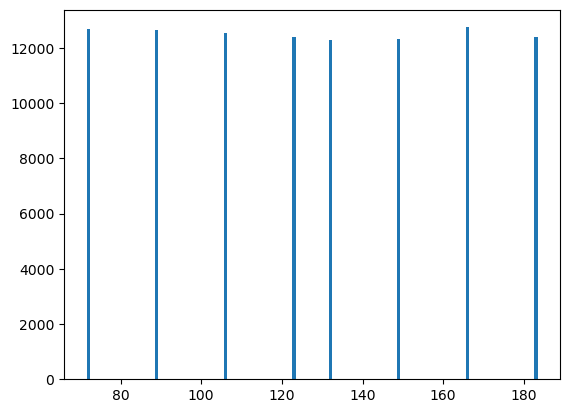

In [142]:
sample_stat = np.unique(samples, return_counts=True)
for i in sample_stat[0]:
    # Possible pairs of uw with non-zero values
    print(perm_pair_uw[i])
plt.bar(sample_stat[0],sample_stat[1])